<a href="https://colab.research.google.com/github/MokshAggarwal/Hate-Speech-Detection/blob/main/Feature_Extraction_and_Baseline_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from collections import Counter
from gensim.models import FastText, Word2Vec
from gensim.test.utils import common_texts
import multiprocessing
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.metrics import f1_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Reading the jigsaw dataset

In [ ]:
xtrain = pd.read_csv('/content/drive/MyDrive/jigsaw dataset/train.csv')
xtrain

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


# Preprocessing
### Simplifying the jigsaw dataset into 2 classes Hate and Non-Hate

In [ ]:
xtrain['category']=''
xtrain['category']=xtrain['toxic'] | xtrain['severe_toxic'] | xtrain['obscene'] | xtrain['identity_hate'] | xtrain['threat'] | xtrain['insult']
display(xtrain)
# xtrain['category'].value_counts()
xtrain.drop(xtrain.columns[[0, 2,3,4,5,6,7]], axis = 1, inplace = True)
display(xtrain)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,category
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0


,comment_text,category
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


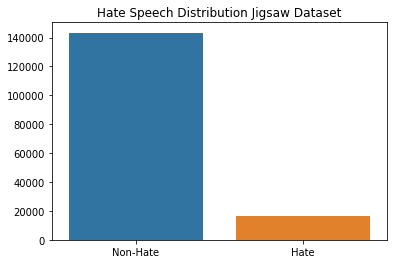

In [ ]:
non_hate, hate = xtrain['category'].value_counts().values
sns.barplot(x=['Non-Hate', 'Hate'],y = [non_hate, hate])
# we can see that the data is highly skewed
plt.title('Hate Speech Distribution Jigsaw Dataset')
plt.show()

### Simplifying the Davidson dataset into 2 classes Hate and Non-Hate

In [ ]:
xtrain2=pd.read_csv('/content/drive/MyDrive/jigsaw dataset/DavidsonHateSpeechData.csv')
xtrain2.drop(xtrain2.columns[[0, 1, 2,3,4]], axis = 1, inplace = True)

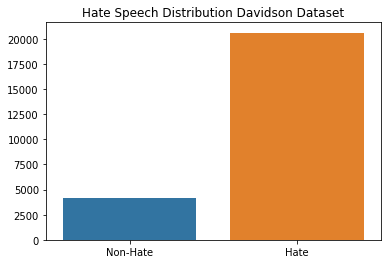

In [ ]:
class_count = dict(Counter(xtrain2['class']))
non_hate = class_count[2]
hate = class_count[0] + class_count[1]

sns.barplot(x=['Non-Hate', 'Hate'],y = [non_hate, hate])
# we can see that the data is highly skewed
plt.title('Hate Speech Distribution Davidson Dataset')
plt.show()

In [ ]:
xtrain2 = xtrain2[xtrain2['class'].values<2]
xtrain2['class']=1
xtrain2.rename(columns = {'class':'category','tweet':'comment_text'}, inplace = True)
display(xtrain2)

,category,comment_text
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
...,...,...
24776,1,you're all niggers
24777,1,you're such a retard i hope you get type 2 dia...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24780,1,young buck wanna eat!!.. dat nigguh like I ain...


### Merging the jigsaw and the davidson datasets 

In [ ]:
final_xtrain = pd.concat([xtrain, xtrain2])
# display(final_xtrain)
print(final_xtrain['category'].value_counts())
final_xtrain

0    143346
1     36845
Name: category, dtype: int64


,comment_text,category
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
24776,you're all niggers,1
24777,you're such a retard i hope you get type 2 dia...,1
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1
24780,young buck wanna eat!!.. dat nigguh like I ain...,1


### Sampling the data to remove extreme skewness

In [ ]:
hate=final_xtrain[final_xtrain['category']==1].sample(n=20000)
non_hate=final_xtrain[final_xtrain['category']==0].sample(n=30000)
final_xtrain=pd.concat([hate, non_hate])
final_xtrain = final_xtrain.sample(frac = 1)
final_xtrain.reset_index(drop=True, inplace=True)
final_df = final_xtrain.applymap(lambda s:s.lower() if type(s) == str else s)


In [ ]:
final_df

,comment_text,category
0,"""\n i shall now re-state what i have previousl...",0
1,"video \n\non disasterpieces, it is stated that...",0
2,"""\n\n nai caste ka veer \n\nfuck you all mothe...",1
3,p.s im a fucking cunt rag and enjoy the taste ...,1
4,why shouldn't i delete all the cast members of...,0
...,...,...
49995,"col. sanders, part 2: ""...and those sons of bi...",1
49996,note to an admin reviewing the unblock request...,0
49997,lets not edit user pages and look like a fucki...,1
49998,). (see you tomorrow!),0


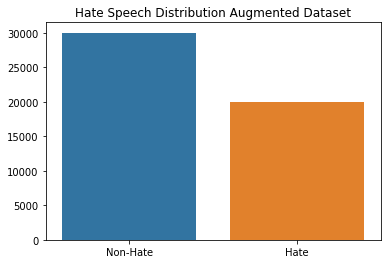

In [ ]:
non_hate, hate = final_df['category'].value_counts().values
sns.barplot(x=['Non-Hate', 'Hate'],y = [non_hate, hate])
# we can see that the data is highly skewed
plt.title('Hate Speech Distribution Augmented Dataset')
plt.show()

### Cleaning the text for better feature extraction


In [ ]:
def cleanString(comment: str) -> str:
    comment = re.sub('n\'t', '', comment)
    comment = re.sub('\'m', '', comment)
    comment = re.sub('\'ve', '', comment)
    comment = re.sub(' to ', ' ', comment)
    comment = re.sub(' the ', ' ', comment)
    comment = re.sub('\'s', '', comment)
    comment = re.sub(' is ', ' ', comment)
    comment = re.sub(' are ', ' ', comment)
    comment = re.sub(' have ', ' ', comment)
    comment = re.sub(' has ', ' ', comment)
    comment = re.sub(' a ', ' ', comment)
    comment = re.sub(' the ', ' ', comment)


    comment = comment.replace('\n', ' ')
    comment = comment.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')    
    comment = comment.replace(r'[0-9]', '')
    # remove punctuation and numbers
    comment = re.sub('[^a-zA-Z!?%]', ' ', comment)
    comment = re.sub('[^a-zA-Z%]', ' ', comment)
    # del %
    comment = re.sub('%', '', comment)
    # remove multiple spaces
    comment = re.sub(r' +', ' ', comment)
    # remove newline
    comment = re.sub(r'\n', ' ', comment)
    # remove digits
    comment = ''.join(i for i in comment if not i.isdigit())
    comment = re.sub(r' +', ' ', comment)
    comment = comment.strip()
    return comment

def split_data(df, size):
  try:
    final_df.drop(final_df.columns[[2, 3]], axis = 1, inplace = True)
  except:
    pass
  #dropping the last column and storing it in the target
  X=df.drop('category',axis='columns') # data 
  Y=df['category'] #  that we need to predict
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = size, random_state = 17)
  return X_train, X_test, Y_train, Y_test

In [ ]:
final_df.comment_text = final_df.comment_text.map(cleanString)

# Exploratory data analysis

### Analyzing the Character count

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9a2bdf110>,
      dtype=object)

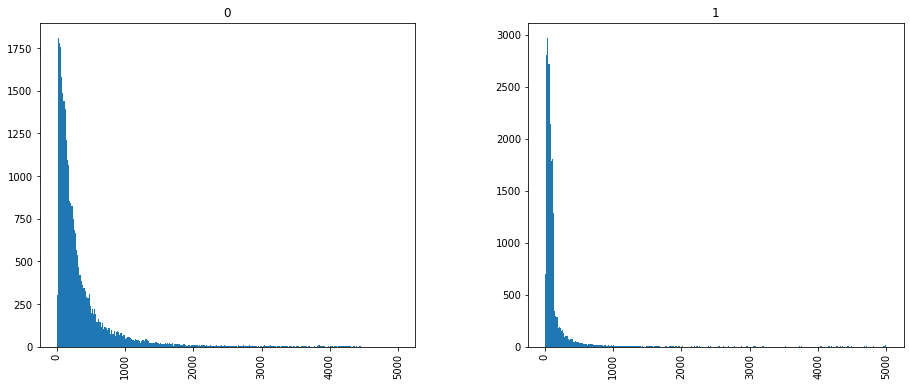

In [ ]:
final_df['Char_Count'] = final_df['comment_text'].apply(len)
final_df.hist(column='Char_Count',by='category',figsize=(15,6), bins=300)
#According to the histograms, cannot see significant different between length of hate and normal comments. The hate comments are relatively of shorter lenghts

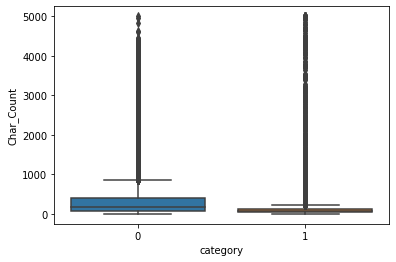

In [ ]:
sns.boxplot(x='category', y='Char_Count', data=final_df)

### Analyzing the Word count

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9a48a87d0>,
      dtype=object)

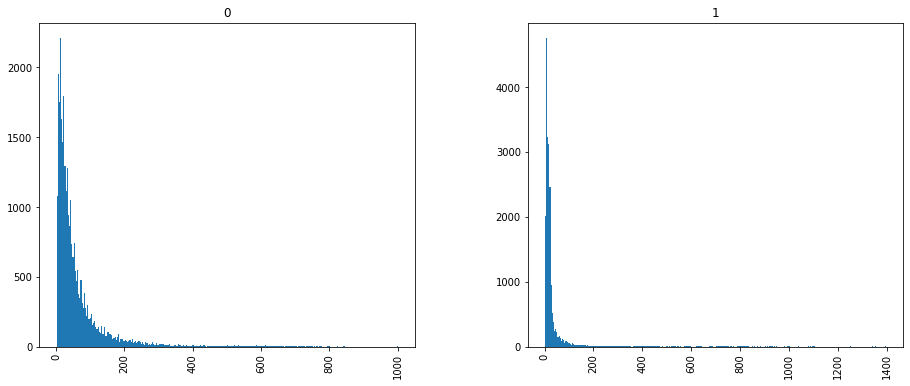

In [ ]:
def func(st):
  lst = st.split(' ')
  return len(lst)

final_df['Word_Count'] = final_df['comment_text'].apply(func)
final_df.hist(column='Word_Count',by='category',figsize=(15,6), bins=300)
#According to the histograms, cannot see significant different between length of hate and normal comments. The hate comments are relatively of shorter lenghts

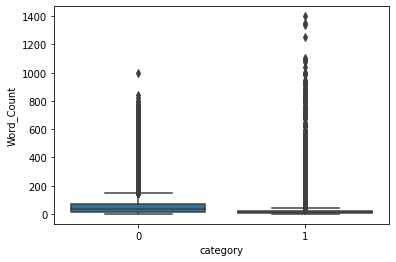

In [ ]:
sns.boxplot(x='category', y='Word_Count', data=final_df)

### Visualizing the Word Cloud of the dataframe 

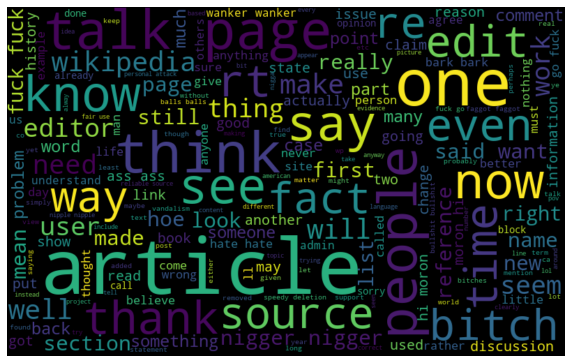

In [ ]:
# visualizing which of the word is most commonly used in the  dataset
from wordcloud import WordCloud
all_words = ' '.join([text for text in final_df['comment_text'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Visualizing the word cloud of hate comments

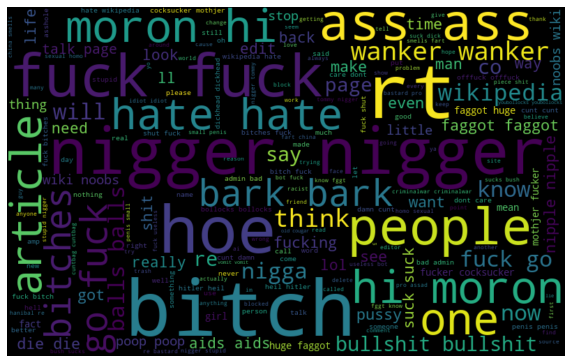

In [ ]:
# visualizing which of the word is most commonly used for hate speech
hate_words = ' '.join([text for text in final_df['comment_text'][final_df['category'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hate_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Visualizing the word cloud of non hate comments

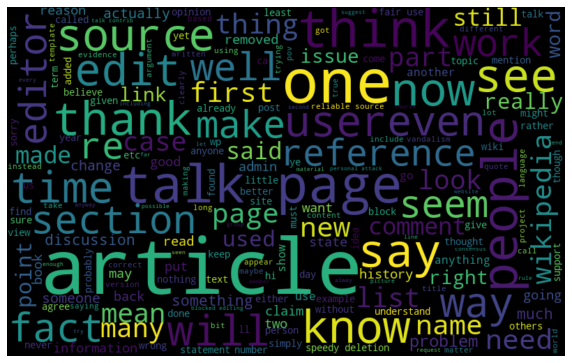

In [ ]:
# visualizing which of the word is most commonly used for non hate speech
non_hate_words = ' '.join([text for text in final_df['comment_text'][final_df['category'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(non_hate_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Train-Test Split

In [ ]:
X_train, X_test, Y_train, Y_test = split_data(final_df, 0.2)
display(X_train.head())
display(Y_train.head())
# final_df

,comment_text
2380,i see enough people here in fl without helmet ...
3385,this page could contain more on history of inf...
41779,jidan i need your help al khwarizmi article be...
39302,october you currently appear be engaged in an ...
20619,i believe so it one of string of examples of s...


2380     0
3385     0
41779    0
39302    0
20619    0
Name: category, dtype: int64

# Char n-gram feature extraction

In [ ]:
vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(5, 8),strip_accents='ascii',min_df=0.1,max_df=0.9)
vectorizer = vectorizer.fit(X_train.comment_text)
countMatrix1 = vectorizer.transform(X_train.comment_text)
countMatrix2 = vectorizer.transform(X_test.comment_text)


In [ ]:
transformer = TfidfTransformer().fit(countMatrix1)
Char_train_feature = transformer.transform(countMatrix1)
Char_test_feature = transformer.transform(countMatrix2)


In [ ]:
# vectorizer.get_feature_names_out().tolist()
print(Char_train_feature.shape, Char_test_feature.shape)

(40000, 147) (10000, 147)


In [ ]:
# print(tfidfMatrix.toarray())

# Word n-gram feature extraction

In [ ]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 4),strip_accents='ascii',min_df=0.1,max_df=0.9)
vectorizer2 = vectorizer2.fit(X_train.comment_text)
countMatrix1 = vectorizer2.transform(X_train.comment_text)
countMatrix2 = vectorizer2.transform(X_test.comment_text)

In [ ]:
transformer=TfidfTransformer().fit(countMatrix1)
Word_train_feature=transformer.transform(countMatrix1)
Word_test_feature=transformer.transform(countMatrix2)

In [ ]:
print(Word_train_feature.shape, Word_test_feature.shape)

(40000, 42) (10000, 42)


In [ ]:
# print(tfidfMatrix.shape)

In [ ]:
# print(tfidfMatrix.toarray())

# FastText features 

In [ ]:
def get_w2vdf(df):
    w2v_df = pd.DataFrame(df["comment_text"]).values.tolist()
    for i in range(len(w2v_df)):
        w2v_df[i] = w2v_df[i][0].split(" ")
    return w2v_df
  
def get_feature_vector(df, model):
  feature_vectors = []
  for i in tqdm(df.index):
    sentence = df.loc[i,'comment_text'].split(' ')
    matrix = model.wv[sentence]
    vector = np.mean(matrix, axis = 0)
    feature_vectors.append(vector.tolist())
    # print(vector)

  return feature_vectors


In [ ]:
tokenized_sentences = get_w2vdf(X_train)
model = FastText(tokenized_sentences, size=100, window=3, min_count=1)

In [ ]:
Fast_train_feature = get_feature_vector(X_train, model)
Fast_test_feature = get_feature_vector(X_test, model)

100%|██████████| 10000/10000 [00:03<00:00, 3121.44it/s]


In [ ]:
# X_train_features

In [ ]:
pd.DataFrame(Fast_train_feature, index = X_train.index)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2380,0.850950,0.785101,-0.346799,-1.328880,-0.282730,-0.343243,-0.399340,1.294882,-0.218908,0.326275,...,-0.439118,-0.908569,0.051655,-0.377462,1.447192,-0.595280,1.790969,-0.175669,-1.039196,-0.729665
3385,0.829764,1.569238,0.538101,0.356340,-0.426514,0.284667,-0.584939,0.270789,-0.737742,0.055441,...,0.219238,-0.833852,-0.425237,0.088801,-0.417155,0.126985,0.537066,0.588049,-0.498483,-0.552678
41779,0.230677,0.373457,-0.125815,-0.555322,-0.499087,-0.270595,-0.040044,1.239125,-0.654990,0.204473,...,-0.282053,-1.185191,-0.126811,0.353746,0.882040,-0.705202,2.095780,-0.098576,-1.646358,-0.588897
39302,0.322718,1.345081,0.300847,-0.090356,-0.604163,0.172736,-0.276400,0.836491,-0.675525,0.669011,...,0.340156,-0.354403,-0.502779,0.135259,0.080139,-0.024986,1.821915,0.474691,-0.900961,-0.243067
20619,0.731125,1.366936,0.021596,-0.596666,-0.697160,0.237025,-0.867006,0.736811,-0.209591,0.098243,...,-0.235246,-1.038456,-0.185967,-0.178381,0.093007,-0.544693,1.181226,0.408396,-0.960468,-0.290249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42297,0.469615,0.365954,0.128625,-0.479479,-0.333748,0.015167,-0.254410,0.600678,-0.703084,0.773618,...,0.276036,-1.019250,0.274892,0.279725,-0.018820,-0.001970,0.964371,0.293647,-1.175755,-0.199213
33174,0.548075,0.630098,-0.186975,-0.677583,-0.447845,-0.497087,-0.377705,1.297615,-0.685521,0.178157,...,-0.608021,-0.912561,-0.067628,0.413377,0.648802,-0.525644,2.206547,-0.074515,-0.841306,-0.445551
46470,0.674435,0.344647,-0.059989,-0.700144,0.096973,-0.382049,-0.256679,1.397659,-0.426256,0.313119,...,-0.187281,-0.743553,-0.036040,-0.386860,1.112821,-0.401805,1.317073,0.087012,-1.431277,-0.411819
34959,-0.117726,0.296866,-0.757226,-1.716419,0.228141,-1.373352,0.130307,1.865040,-0.091754,0.350026,...,-0.484962,-0.293949,0.467446,0.259577,1.662445,-0.665271,2.011983,-0.034996,-1.631905,-0.267999


In [ ]:
X_train_features_final=np.concatenate([Char_train_feature.todense(), Word_train_feature.todense(), Fast_train_feature],axis=1)
X_train_features_final.shape
X_train_features_final=pd.DataFrame(X_train_features_final)
X_train_features_final

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,288
0,0.000000,0.00000,0.000000,0.0,0.000000,0.172509,0.000000,0.000000,0.000000,0.000000,...,-0.439118,-0.908569,0.051655,-0.377462,1.447192,-0.595280,1.790969,-0.175669,-1.039196,-0.729665
1,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.219238,-0.833852,-0.425237,0.088801,-0.417155,0.126985,0.537066,0.588049,-0.498483,-0.552678
2,0.000000,0.00000,0.000000,0.0,0.290058,0.000000,0.135587,0.136354,0.136478,0.136507,...,-0.282053,-1.185191,-0.126811,0.353746,0.882040,-0.705202,2.095780,-0.098576,-1.646358,-0.588897
3,0.000000,0.00000,0.000000,0.0,0.093162,0.059264,0.000000,0.000000,0.000000,0.000000,...,0.340156,-0.354403,-0.502779,0.135259,0.080139,-0.024986,1.821915,0.474691,-0.900961,-0.243067
4,0.000000,0.00000,0.000000,0.0,0.000000,0.124896,0.000000,0.000000,0.000000,0.000000,...,-0.235246,-1.038456,-0.185967,-0.178381,0.093007,-0.544693,1.181226,0.408396,-0.960468,-0.290249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.000000,0.00000,0.000000,0.0,0.000000,0.266637,0.000000,0.000000,0.000000,0.000000,...,0.276036,-1.019250,0.274892,0.279725,-0.018820,-0.001970,0.964371,0.293647,-1.175755,-0.199213
39996,0.000000,0.00000,0.000000,0.0,0.000000,0.079177,0.000000,0.000000,0.000000,0.000000,...,-0.608021,-0.912561,-0.067628,0.413377,0.648802,-0.525644,2.206547,-0.074515,-0.841306,-0.445551
39997,0.175637,0.17566,0.175682,0.0,0.000000,0.217257,0.000000,0.000000,0.000000,0.000000,...,-0.187281,-0.743553,-0.036040,-0.386860,1.112821,-0.401805,1.317073,0.087012,-1.431277,-0.411819
39998,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.484962,-0.293949,0.467446,0.259577,1.662445,-0.665271,2.011983,-0.034996,-1.631905,-0.267999


In [ ]:
X_test_features_final=np.concatenate([Char_test_feature.todense(), Word_test_feature.todense(), Fast_test_feature],axis=1)
X_test_features_final.shape
X_test_features_final=pd.DataFrame(X_test_features_final)
X_test_features_final

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,288
0,0.189285,0.189309,0.189333,0.000000,0.000000,0.058535,0.086025,0.086511,0.08659,0.086609,...,-0.385939,-0.813905,0.379172,0.076131,0.844991,-0.734674,2.385307,0.165119,-1.429066,-0.015423
1,0.000000,0.000000,0.000000,0.000000,0.239462,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.021092,-0.705222,-0.327585,-0.121961,-0.268225,-0.019720,1.070444,0.167299,-0.827628,-0.435321
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,-1.127216,-0.845140,0.078843,-0.182377,1.775453,-0.457391,2.150767,-0.294474,-1.911294,-0.479492
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,-0.381790,-0.962693,-0.110251,-0.449596,0.840496,-0.375900,1.286999,0.192714,-1.293139,-0.343049
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,-0.866169,-0.182887,0.409372,-0.763585,2.533788,-1.147647,1.869004,0.474145,-1.527787,0.020764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.000000,0.000000,0.134448,0.000000,0.082448,0.000000,0.000000,0.00000,0.000000,...,-0.032870,-0.573390,-0.035267,-0.025111,-0.488732,-0.594281,1.727601,0.500564,-0.248324,-0.605174
9996,0.000000,0.000000,0.000000,0.000000,0.000000,0.089949,0.000000,0.000000,0.00000,0.000000,...,0.071015,-0.585726,0.323500,0.036877,0.500916,0.094621,1.416762,0.361090,-1.200712,-0.508902
9997,0.000000,0.000000,0.000000,0.142454,0.000000,0.262071,0.000000,0.000000,0.00000,0.000000,...,-0.164107,-0.414914,-0.177094,-0.054685,0.284385,-0.374772,1.698376,-0.057661,-0.989756,-0.304989
9998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,-1.077439,-1.180002,0.602656,-0.616344,1.934976,-0.808740,1.748141,-0.200789,-1.616671,-0.936971


# TSNE Plot

In [ ]:
tsne_df =  X_train_features_final.sample(5000 , random_state=0)
labels = Y_train.iloc[tsne_df.index].to_list() 
tsne_arr =tsne_df.to_numpy()
tsne = TSNE(random_state=0,n_components=2)
tsne_results = tsne.fit_transform(tsne_arr)

Text(0.5, 1.0, 't-SNE plot for random 5000 points')

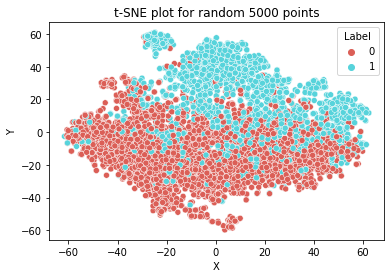

In [ ]:
tsne_df=pd.DataFrame(columns=['X','Y','Label'])
tsne_df['X']=tsne_results[:,0]
tsne_df['Y']=tsne_results[:,1]
tsne_df['Label']=labels
palette = sns.color_palette("hls", 2)
sns.scatterplot(x="X", y="Y", data=tsne_df, hue="Label",palette=palette)
plt.title('t-SNE plot for random 5000 points')

# Logistic Regression

In [ ]:
model=LogisticRegression()
model.fit(X_train_features_final,Y_train)
y_pred=model.predict(X_test_features_final)
f1_score(Y_test,y_pred,average='macro')

0.9082731085986406

# Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train_features_final,Y_train)
y_pred=gnb.predict(X_test_features_final)
f1_score(Y_test,y_pred,average='macro')

0.7972392573886773

# Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train_features_final,Y_train)
y_pred=clf.predict(X_test_features_final)
f1_score(Y_test,y_pred,average='macro')

0.8327221515666174